# --- 01. Data loading and EDA --- #

Загрузка, чистка, исследовательский анализ и создание признаков для датасета Adult (Census Income)

In [1]:
# --- Импорты и константы --- #

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, logging, os
import random
import shutil
from IPython import get_ipython
from scipy import stats
from scipy.stats import chi2_contingency
from pathlib import Path

# настройка графиков и шрифтов #
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set(style='whitegrid', palette='muted', font_scale=1.1)

# точечные фильтры #
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*Glyph .* missing from current font.*')
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*FixedFormatter should only be used with FixedLocator.*')
warnings.filterwarnings('ignore', category=FutureWarning,
                        message='.*is_categorical_dtype is deprecated.*')

rng = np.random.default_rng(42)

In [2]:
# --- Project paths bootstrip --- #

# imports & paths #
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# предоставление Jupyter доступа к модулям из корня проекта #
ROOT = Path.cwd()
while not any((ROOT / m).exists() for m in ('.git', 'README.md', 'environment.yml')) and ROOT.parent != ROOT:
    ROOT = ROOT.parent
RAW_DIR = ROOT / 'data' / 'raw'

if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from paths import (ROOT, DATA_DIR, RAW_DIR, INT_DIR, PROC_DIR, ART_DIR,
                   REPORTS_DIR, MODELS_DIR, NB_DIR)
print(f'[paths] ROOT = {ROOT}')

[paths] ROOT = C:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02


In [3]:
# --- Notebook preamble: silence & style --- #

# тихие логгеры #
logging.getLogger('lightgbm').setLevel(logging.ERROR)
logging.getLogger('xgboost').setLevel(logging.ERROR)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logging.getLogger('numba').setLevel(logging.ERROR)

# красивые графики и кириллица без предупреждений о 'glyphs' #
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# адресные централизованные фильтры предупреждений #
warnings.filterwarnings('ignore', category=UserWarning,
                        message='.*LightGBM binary classifier.*TreeExplainer.*')
warnings.filterwarnings('ignore', category=FutureWarning,
                        message='.*Numpy global RNG was seeded.*')
warnings.filterwarnings('ignore', category=FutureWarning,
                        message='.*pandas.*allow_gtml.*')

# полностью скрыть DeprecationWarning #
warnings.filterwarnings('ignore', category=DeprecationWarning)

# без спама от Jupyter магии autereload #
ip = get_ipython()
if ip:
    try:
        ip.run_line_magic('load_ext', 'autoreload')
    except Exception:
        pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# --- Загрузка данных --- #

# присвоение имен столбцам #
col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
             'marital-status', 'occupation', 'relationship', 'race', 'sex',
             'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
             'income']

cat_cols = ['workclass', 'education', 'marital-status', 'occupation',
            'relationship', 'race', 'sex', 'native-country', 'income']

dtype_map = {c: 'category' for c in cat_cols}
dtype_map.update({
    'age':              'int64',
    'fnlwgt':           'int64',
    'education-num':    'int64',
    'capital-gain':     'int64',
    'capital-loss':     'int64',
    'hours-per-week':   'int64'
})

df_train =  pd.read_csv(
    RAW_DIR / 'adult.data',
    header=None,  names=col_names, sep=',',
    na_values='?', dtype=dtype_map)

df_test =   pd.read_csv(
    RAW_DIR / 'adult.test',
    header=None, names=col_names, sep=',',
    skiprows=1, na_values='?',  dtype=dtype_map)

# объединение train и test для EDA #
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# очищение от хвостов и точек в income #
if pd.api.types.is_categorical_dtype(df['income']):
    df['income'] = df['income'].astype('string')

# нормализация income и создание бинарного признака #
df['income'] = df['income'].str.replace('.', '', regex=False).str.strip()
df['income'] = df['income'].astype('category')

df['income_bin'] = (df['income'] == '>50K').astype('int8')

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,income_bin
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,0


In [5]:
# --- Первичный обзор --- #

print('Shape:', df.shape)
display(df.describe(include=[np.number]).T)

obj_cols = df.select_dtypes(include=['object', 'category']).columns
if len(obj_cols) > 0:
    display(df[obj_cols].describe().T)

Shape: (48842, 16)


,count,mean,std,min,25%,50%,75%,max
age,48842.0,38.643585,13.710510,17.0,28.0,37.0,48.0,90.0
fnlwgt,48842.0,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education-num,48842.0,10.078089,2.570973,1.0,9.0,10.0,12.0,16.0
capital-gain,48842.0,1079.067626,7452.019058,0.0,0.0,0.0,0.0,99999.0
capital-loss,48842.0,87.502314,403.004552,0.0,0.0,0.0,0.0,4356.0
hours-per-week,48842.0,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0
income_bin,48842.0,0.239282,0.426649,0.0,0.0,0.0,0.0,1.0


,count,unique,top,freq
workclass,48842,9,Private,33906
education,48842,16,HS-grad,15784
marital-status,48842,7,Married-civ-spouse,22379
occupation,48842,15,Prof-specialty,6172
relationship,48842,6,Husband,19716
race,48842,5,White,41762
sex,48842,2,Male,32650
native-country,48842,42,United-States,43832
income,48842,2,<=50K,37155


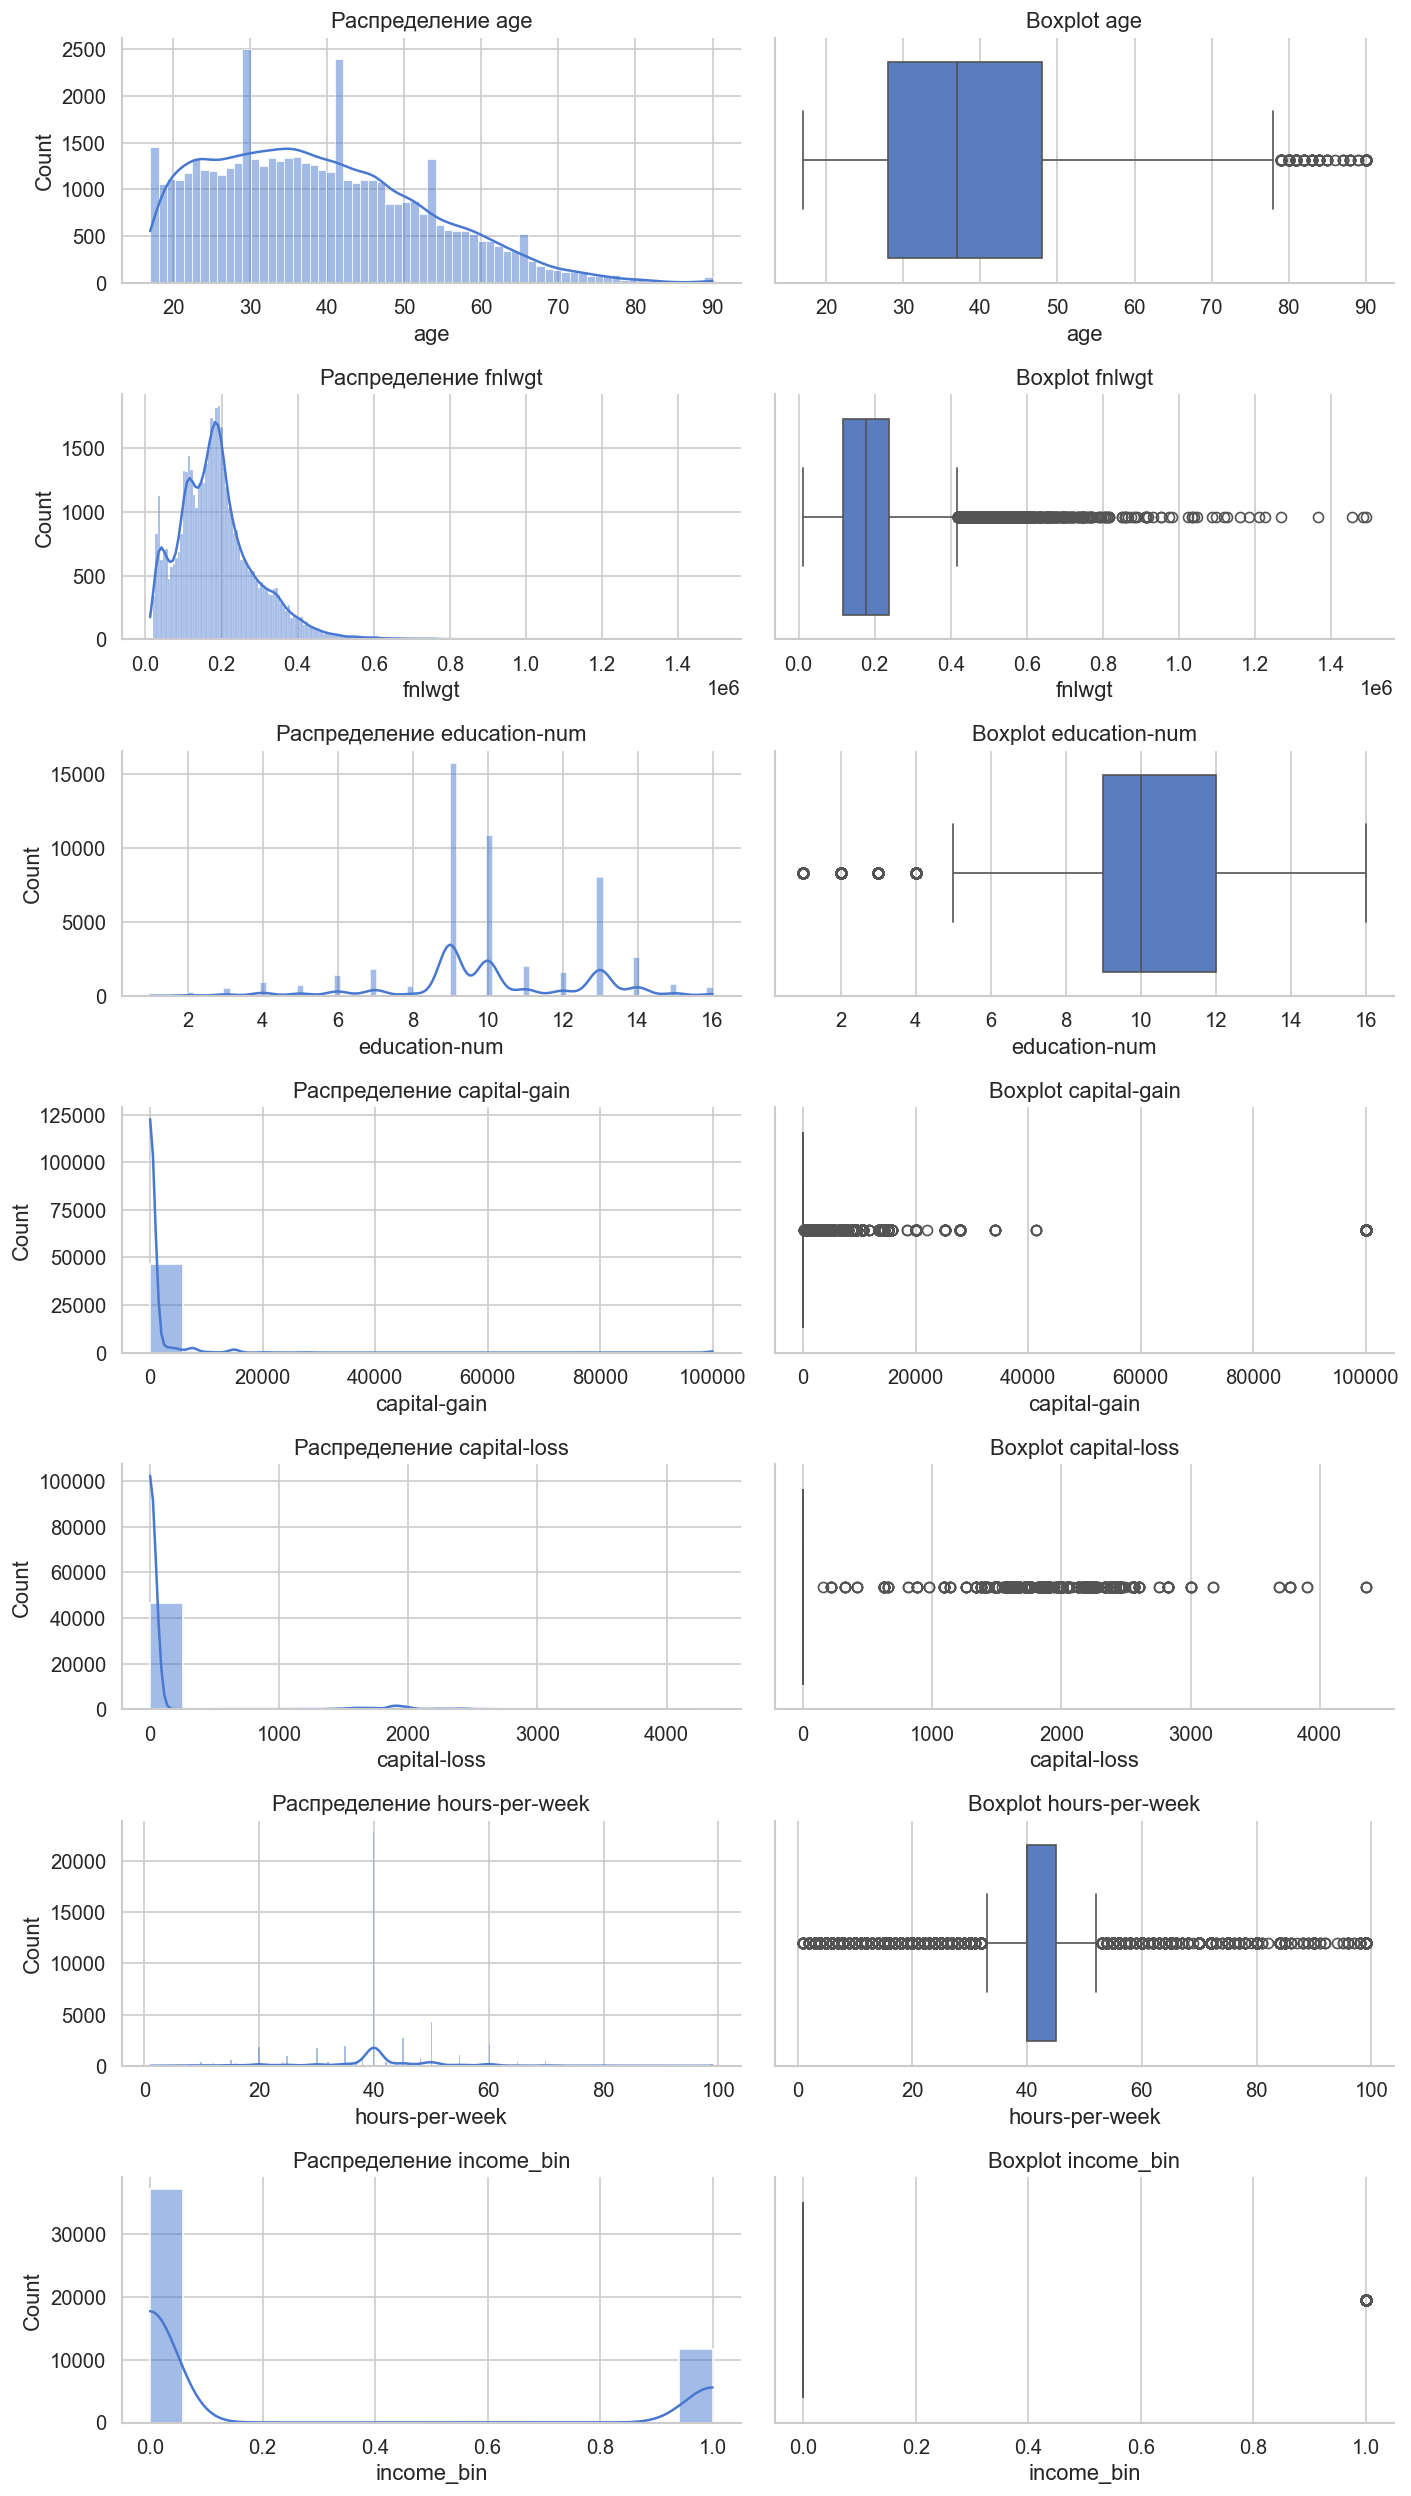

In [6]:
# --- Визуализация распределений числовых признаков --- #

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
fig, axes = plt.subplots(len(num_cols), 2, figsize=(12, max(2, len(num_cols))*3))

for i, col in enumerate(num_cols):
    sns.histplot(df[col].dropna(), kde=True, ax=axes[i,0])
    sns.boxplot(x=df[col].dropna(), ax=axes[i,1])
    axes[i,0].set_title(f'Распределение {col}')
    axes[i,1].set_title(f'Boxplot {col}')

plt.tight_layout()
plt.show()

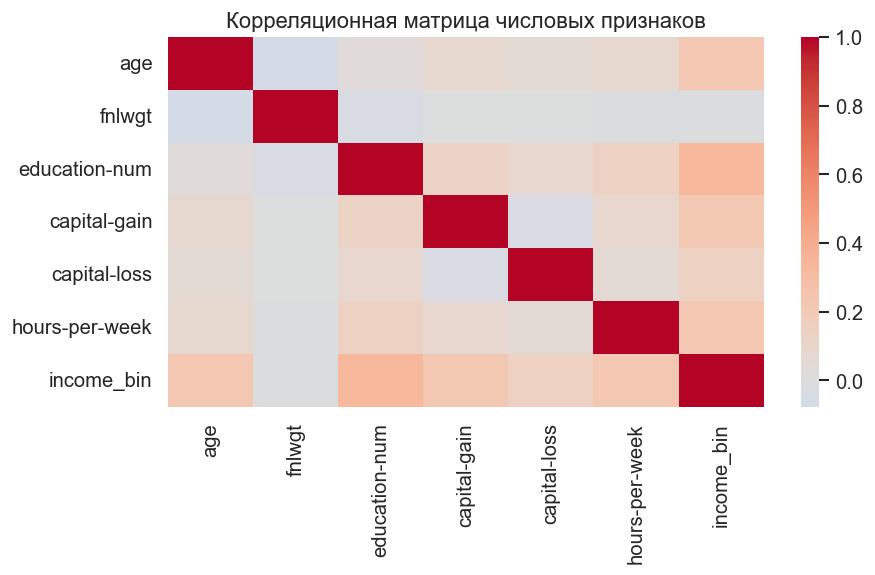

In [7]:
# --- Корреляционная матрица --- #

num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица числовых признаков')
plt.show()

In [8]:
# --- Cramér's V для категориальных признаков --- #

def cramers_v(tbl: pd.DataFrame) -> float:
    chi2, p, dof, exp = chi2_contingency(tbl, correction=False)
    n = tbl.values.sum()
    if n == 0:
        return np.nan
    phi2 = chi2 / n
    r, k = tbl.shape
    return np.sqrt(phi2 / max(1, min(k - 1, r - 1)))

cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
if len(cat_cols) > 0:
    cv_matrix = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
    for c1 in cat_cols:
        for c2 in cat_cols:
            if c1 == c2:
                cv_matrix.loc[c1, c2] = 1.0
            else:
                tbl = pd.crosstab(df[c1].dropna(), df[c2].dropna())
                cv_matrix.loc[c1, c2] = cramers_v(tbl)
    display(cv_matrix)

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
workclass,1.000000,0.099984,0.085464,0.400050,0.100793,0.058303,0.151785,0.042815,0.181601
education,0.099984,1.000000,0.090933,0.186738,0.122675,0.072984,0.093250,0.130263,0.365868
marital-status,0.085464,0.090933,1.000000,0.131653,0.488160,0.083009,0.459453,0.066058,0.448302
occupation,0.400050,0.186738,0.131653,1.000000,0.178249,0.078906,0.424215,0.068801,0.350001
relationship,0.100793,0.122675,0.488160,0.178249,1.000000,0.097512,0.646542,0.079318,0.454487
race,0.058303,0.072984,0.083009,0.078906,0.097512,1.000000,0.113968,0.401647,0.099857
sex,0.151785,0.093250,0.459453,0.424215,0.646542,0.113968,1.000000,0.061072,0.214628
native-country,0.042815,0.130263,0.066058,0.068801,0.079318,0.401647,0.061072,1.000000,0.096224
income,0.181601,0.365868,0.448302,0.350001,0.454487,0.099857,0.214628,0.096224,1.000000


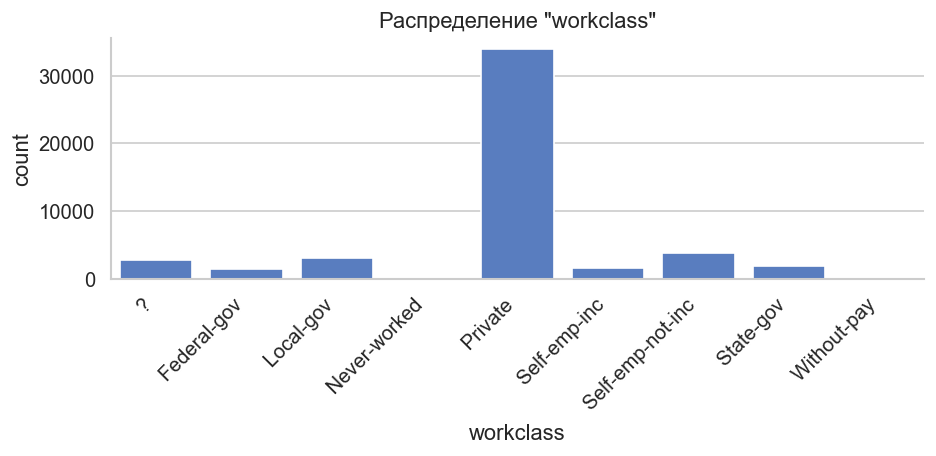

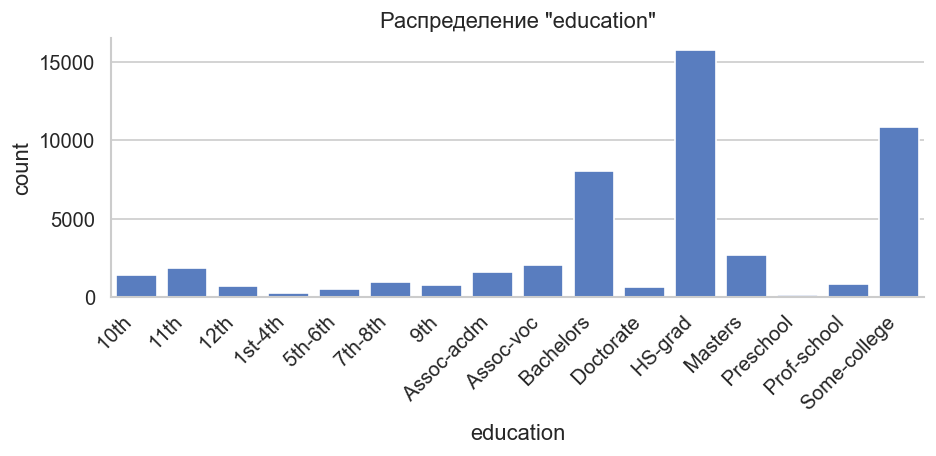

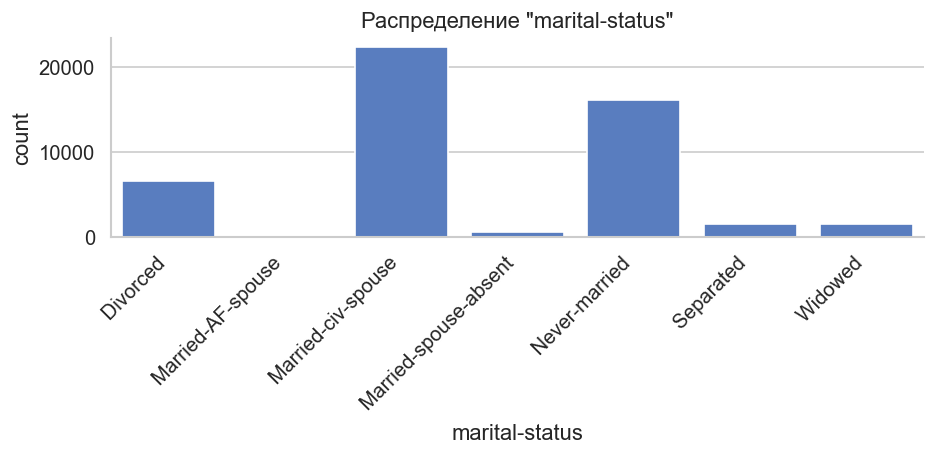

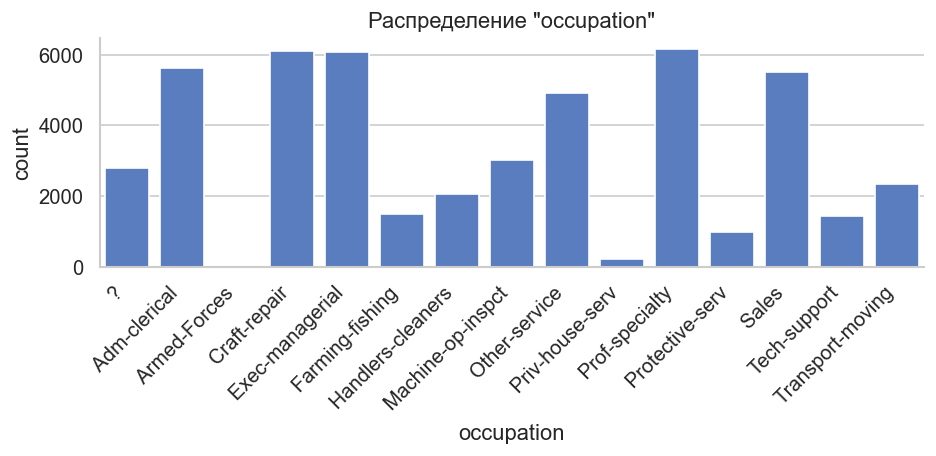

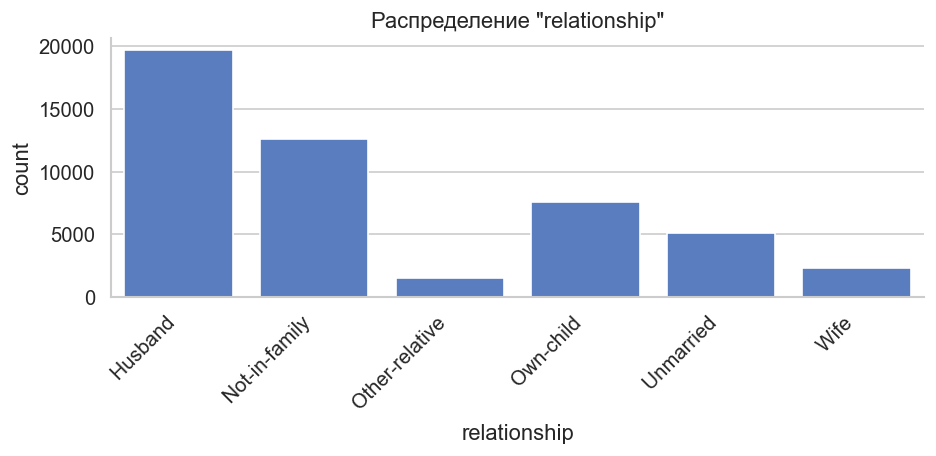

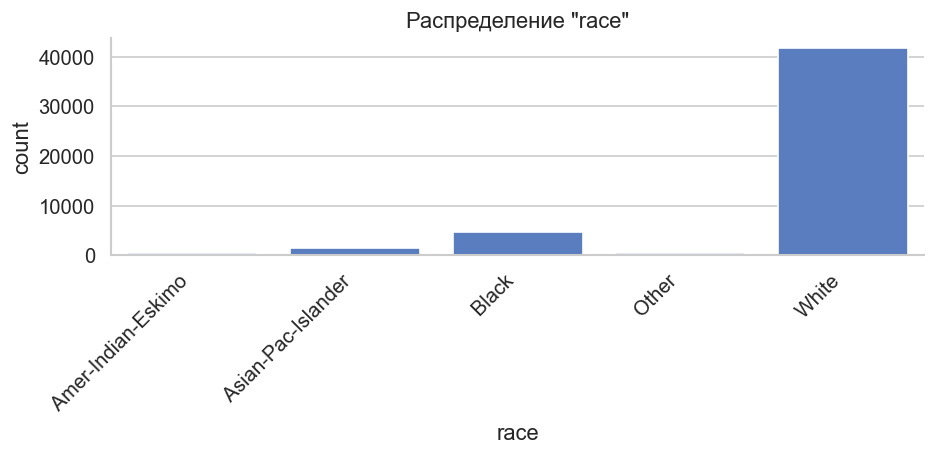

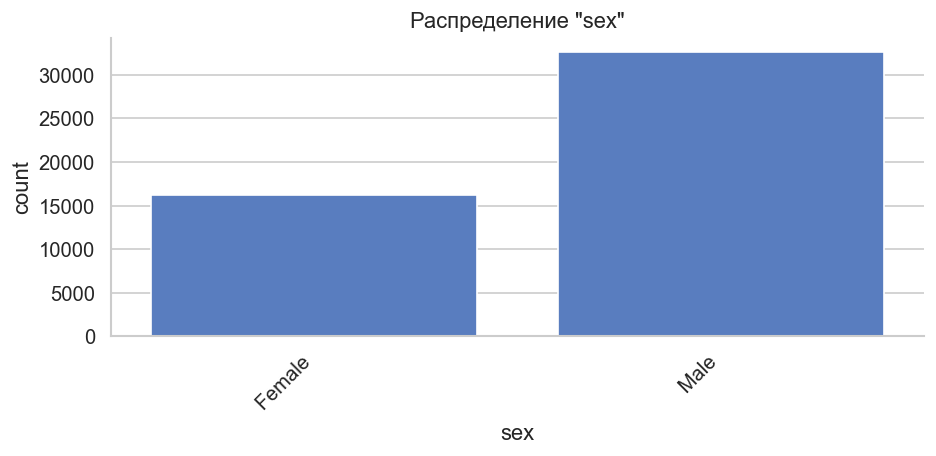

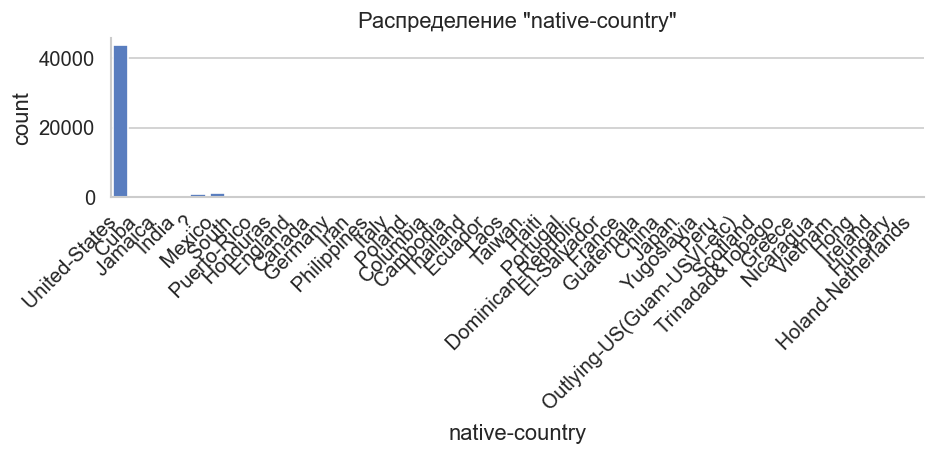

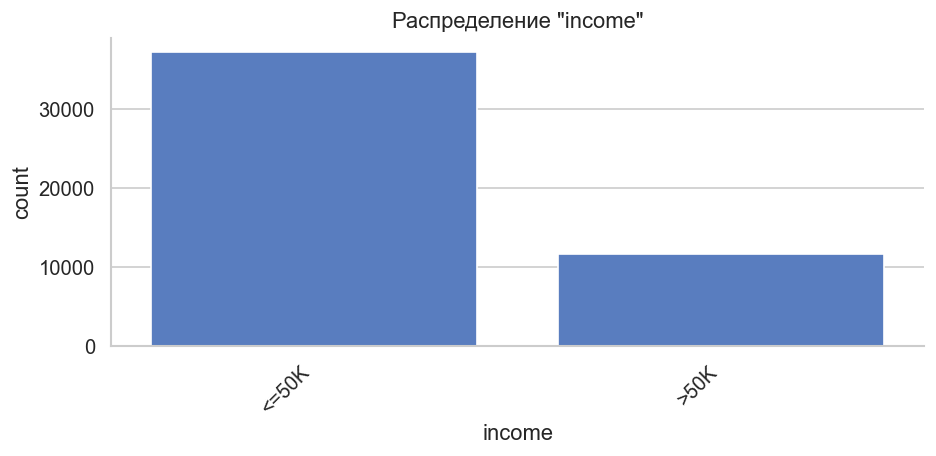

In [9]:
# --- Анализ категориальных признаков --- #

cat_cols = df.select_dtypes(include=['object', 'category']).columns
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=df[col].dropna())
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Распределение "{col}"')
    plt.tight_layout()
    plt.show()

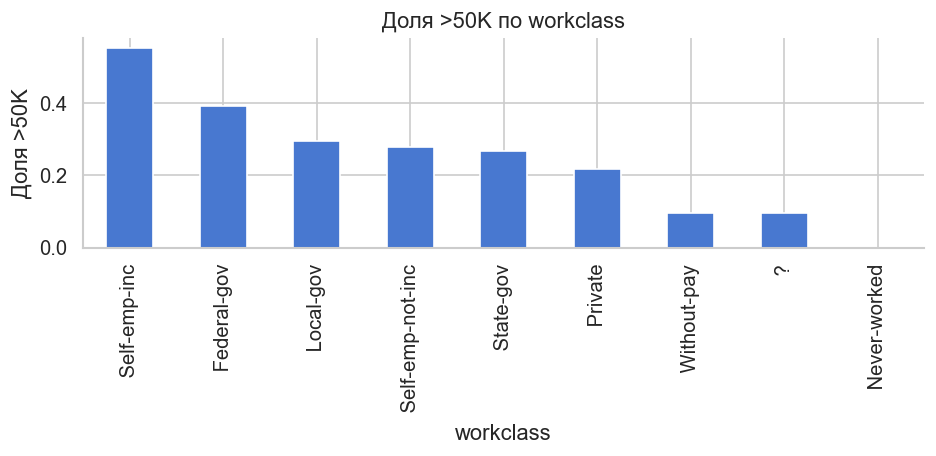

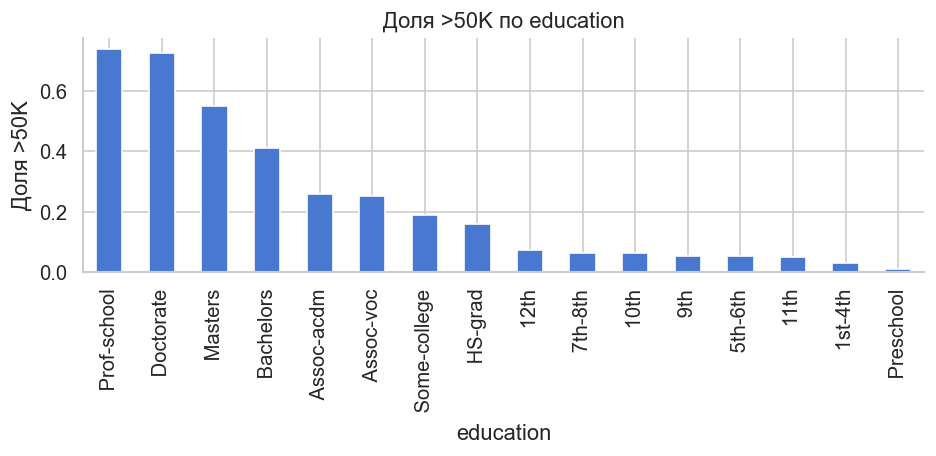

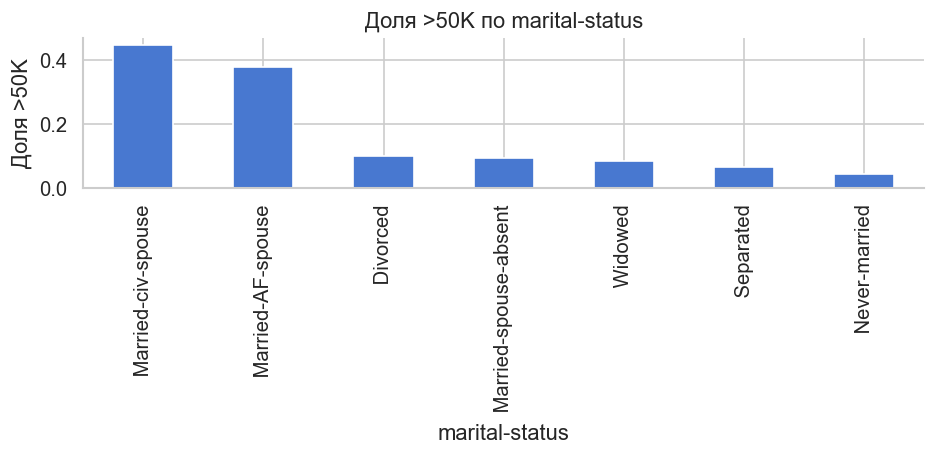

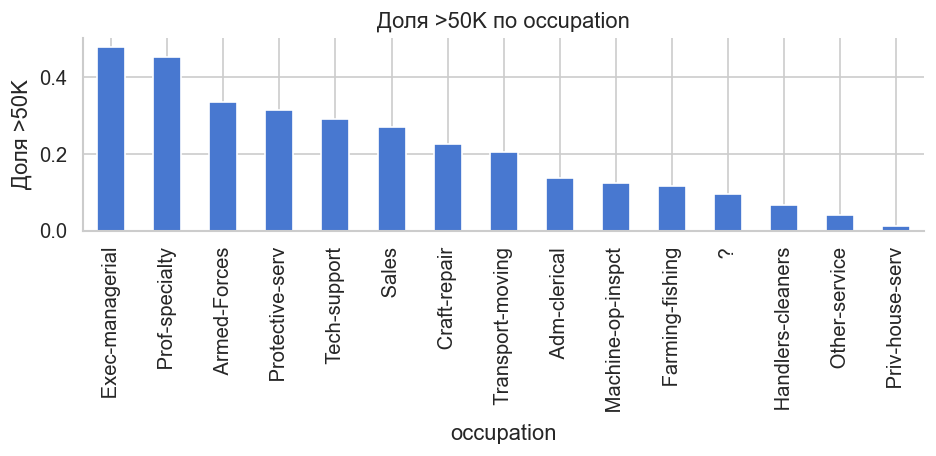

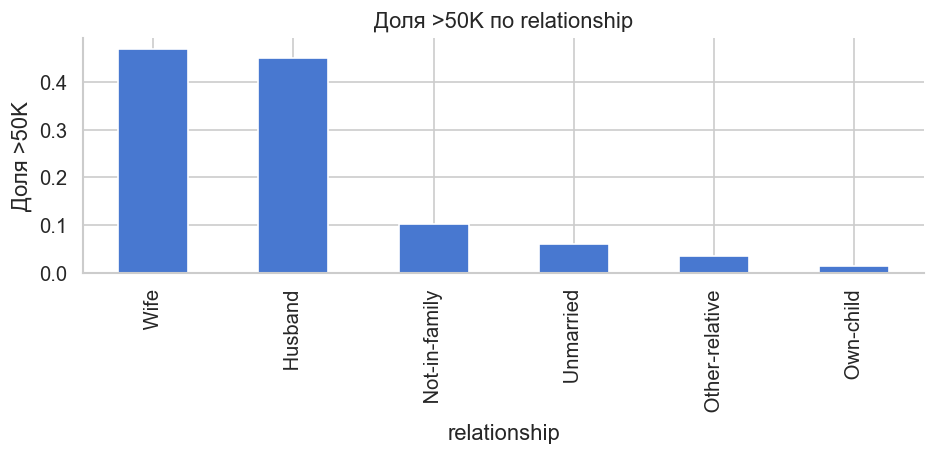

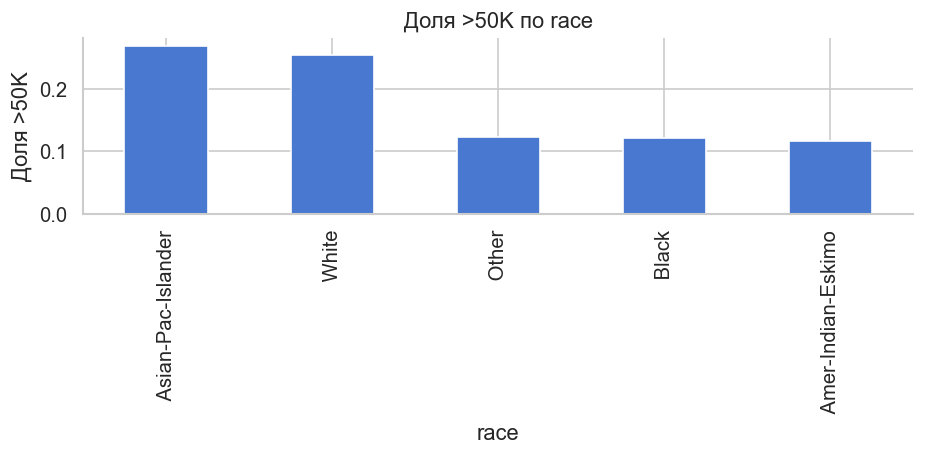

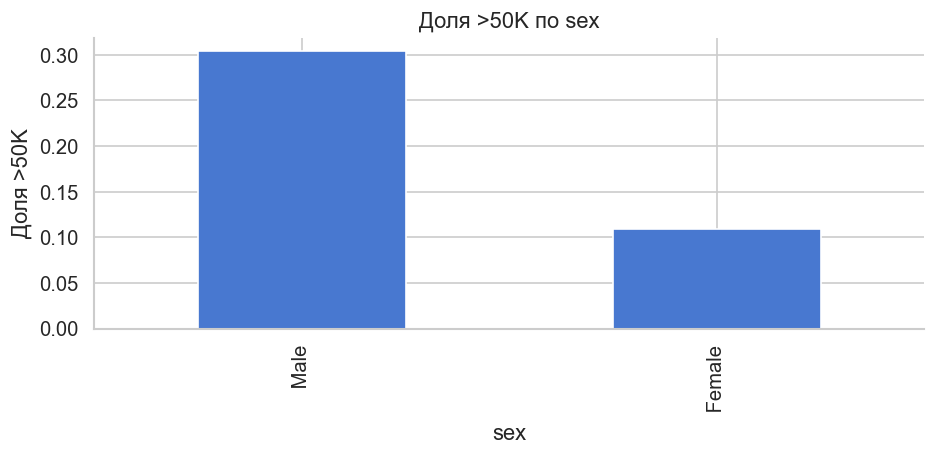

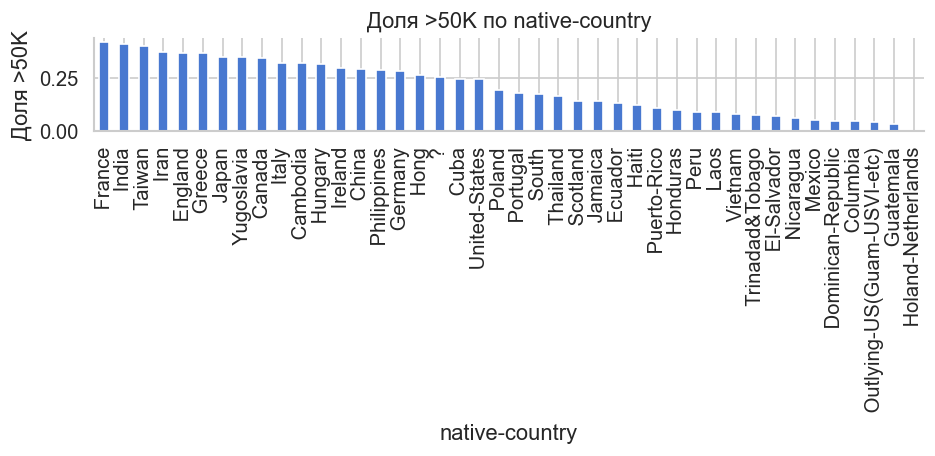

In [10]:
# --- Bivariate Analysis: категориальные признаки vs income --- #

cat_cols = [c for c in df.select_dtypes(include=['object', 'category']).columns if c != 'income']

# приведение object к category #
obj_cols = df.select_dtypes(include=['object']).columns.tolist()
for c in obj_cols:
    if c != 'income':
        df[c] = df[c].astype('category')

for col in cat_cols:
    rates = (df.dropna(subset=[col])
             .groupby(col, observed=True)['income_bin']
             .mean()
             .sort_values(ascending=False))
    ax = rates.plot(kind='bar', figsize=(8, 4))
    ax.set_ylabel('Доля >50K')
    plt.title(f'Доля >50K по {col}')
    plt.tight_layout()
    plt.show()
    

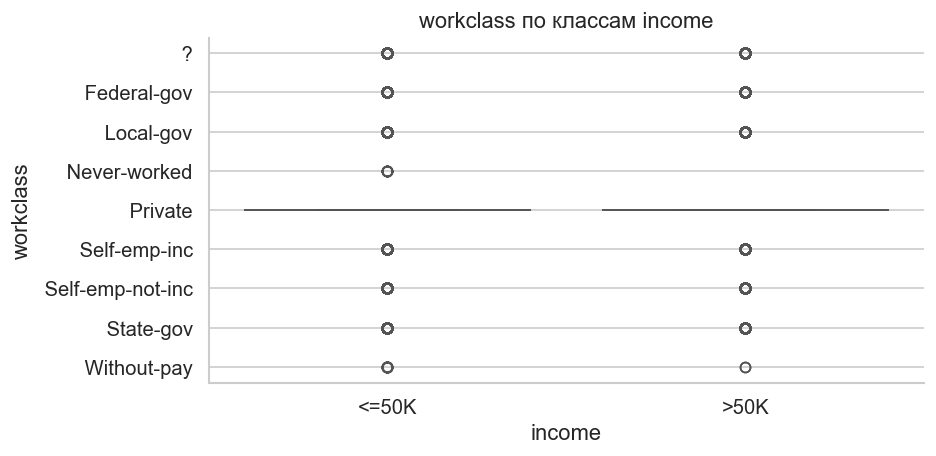

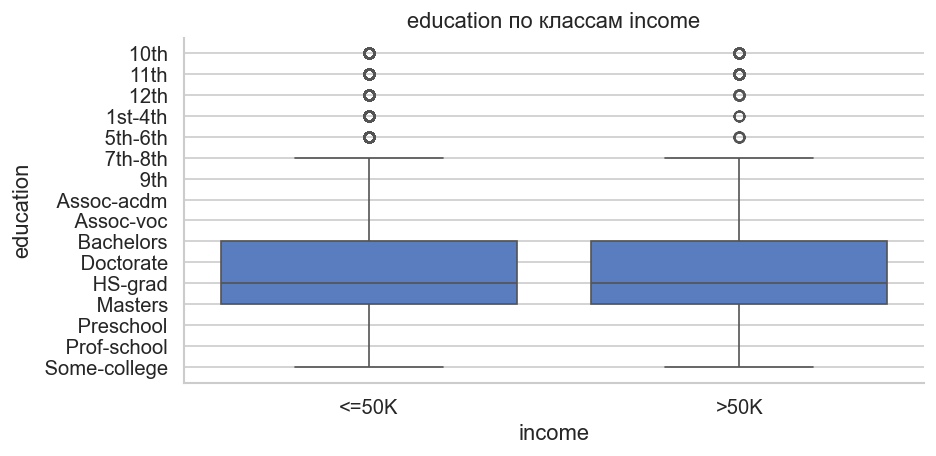

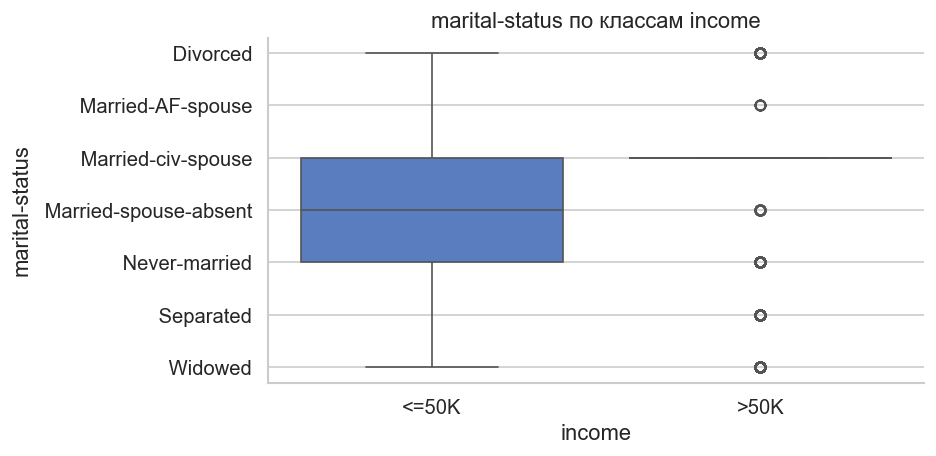

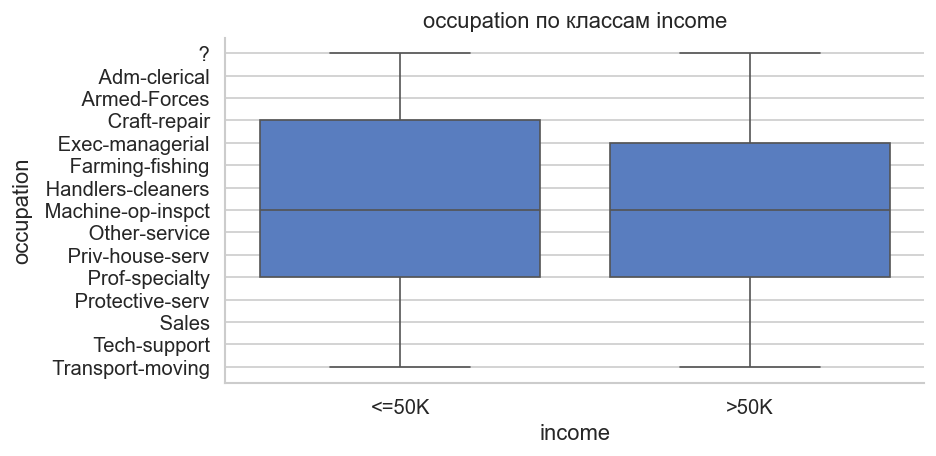

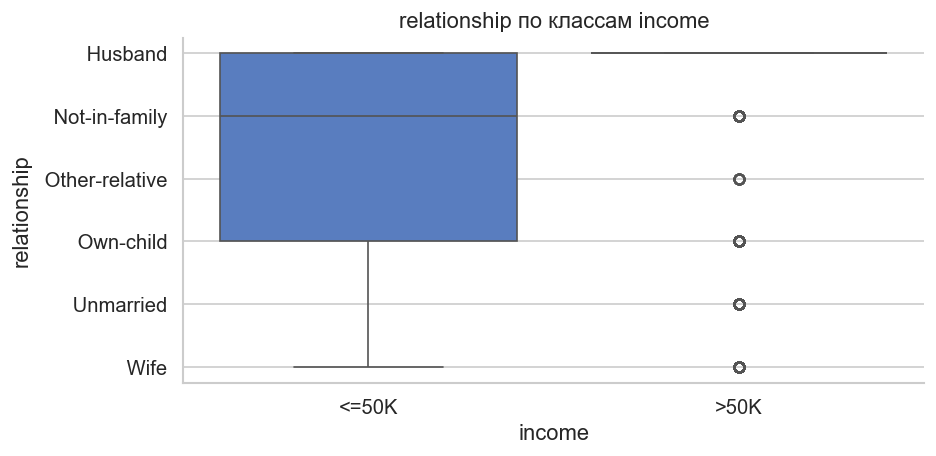

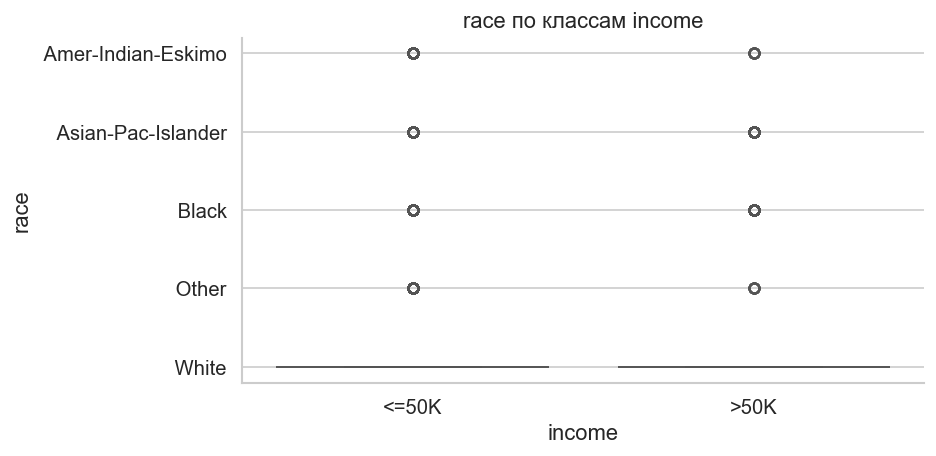

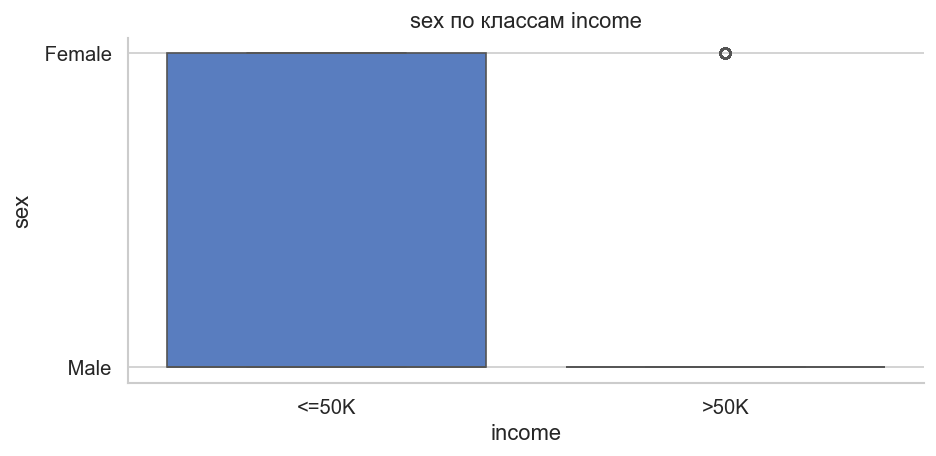

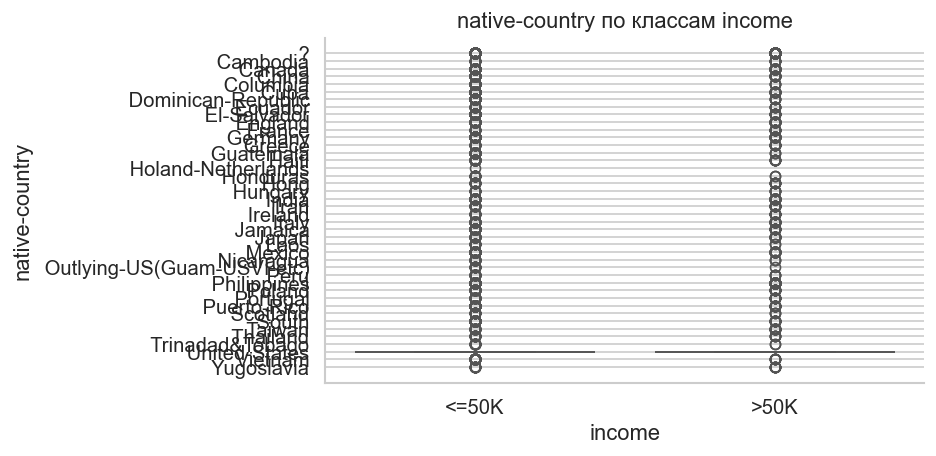

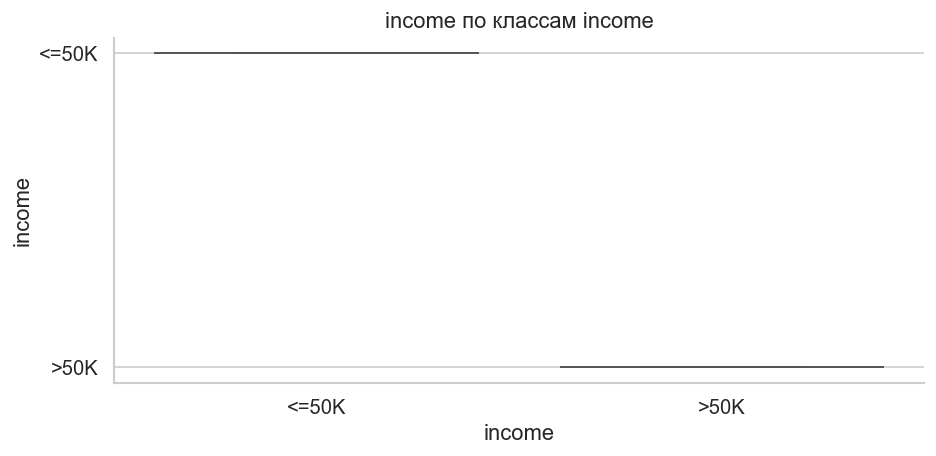

In [11]:
# --- Bivariate Analysis: числовые признаки vs income --- #

num_cols = [c for c in df.select_dtypes(include=['object', 'category']).columns if c != 'income_bin']
for col in num_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=df['income'].astype('category'), y=df[col].dropna())
    plt.title(f'{col} по классам income')
    plt.tight_layout()
    plt.show()

In [12]:
# --- Анализ пропусков и их влияние на целевую переменную --- #

missing = df.isna().mean().sort_values(ascending=False)
display(missing[missing > 0])

# простая проверка: доля >50K среди NaN vs не-NaN для столбцов с пропусками #
for col, ratio in missing[missing > 0].items():
    tmp = df[[col, 'income_bin']].copy()
    tmp['is_null'] = tmp[col].isna().astype(int)
    rates = tmp.groupby('is_null', observed=True)['income_bin'].mean()
    print(f'{col}: income_bin mean if NaN={rates.get(1, np.nan):.3f} vs not-NaN={rates.get(0, np.nan):.3f}')

Series([], dtype: float64)

In [13]:
# --- Поиск выбросов с помощью IQR и визуализация --- #

num_cols = ['age', 'education-num', 'hours-per-week', 'capital-gain', 'capital-loss']
for col in num_cols:
    series = df[col].dropna()
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = ((series < lower) | (series > upper)).sum()
    print(f'{col}: выбросов = {outliers}')

age: выбросов = 216
education-num: выбросов = 1794
hours-per-week: выбросов = 13496
capital-gain: выбросов = 4035
capital-loss: выбросов = 2282


In [14]:
# --- Функция add_custom_features(df) --- #

def add_custom_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()

    # бинарный флаг #
    df['work_isprivate'] = (df['workclass'].astype('string') == 'Private').astype('int8')

    # логарифмические признаки (без предупреждений для NaN/отрицательных) #
    for col in ['capital-gain', 'capital-loss']:
        s = df[col].astype('float64')
        s = s.where(s >= 0) # оставим NaN для отрицательных
        df[col + '_log1p'] = np.log1p(s)
    
    return df

df = add_custom_features(df)

In [15]:
# --- Биннинг возраста: признак age_group (EDA) --- #

df['age_group'] = pd.cut(
    df['age'].astype('float64'),
    bins=[17, 25, 45, 65, 100],
    labels=['18-25', '26-45', '46-65', '65+'],
    include_lowest=True
).astype('category')

In [16]:
# --- Экспорт готового EDA-датасета --- #

PROC_DIR.mkdir(parents=True, exist_ok=True)

try:
    df.to_parquet(PROC_DIR / 'adult_eda.parquet', index=False)
except Exception as e:
    print(f'[warn] Parquet не записан ({e}). Пропускаю.')

df.to_csv(PROC_DIR / 'adult_eda.csv', index=False)

In [17]:
# --- Exports figures (EDA) --- #

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

FIG_DIR = PROJECT_ROOT / 'reports' / 'figures_01'
FIG_DIR.mkdir(parents=True, exist_ok=True)

def _pick_df_from_globals():
    # поиск первого DataFrame среди типичных имен #
    cand_names = ['df', 'data', 'adult', 'X', 'X_train', 'train_df']
    g = globals()
    for name in cand_names:
        if name in g and isinstance(g[name], pd.DataFrame):
            return g[name]
    # любой DF в globals() #
    for v in g.values():
        if isinstance(v, pd.DataFrame):
            return v
    return None

df_eda = _pick_df_from_globals()
if df_eda is None:
    print('[warn] EDA export: не найден DataFrame - пропуск сохранения графиков.')
else:
    # до 8 числовых колонок, чтобы сделать дистрибутивы #
    num_cols = df_eda.select_dtypes(include=[np.number]).columns.tolist()[:8]

    # гистограммы (расклад по колонкам) #
    if num_cols:
        n = len(num_cols)
        ncols = 4
        nrows = int(np.ceil(n / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
        axes = np.array(axes).reshape(-1)
        for i, col in enumerate(num_cols):
            ax = axes[i]
            df_eda[col].dropna().hist(ax=ax, bins=30)
            ax.set_title(col)
        # скрыть пустые оси
        for j in range(i+1, len(axes)):
            axes[j].axis('off')
        fig.suptitle('Numeric distributions (sample up to 8 cols)', y=1.02)
        plt.tight_layout()
        fig.savefig(FIG_DIR / 'eda_numeric_distributions.png', dpi=150)
        plt.close(fig)
        print('Saved:', FIG_DIR / 'eda_numeric_distributions.png')
    else:
        print('[info] EDA export: нет числовых колонок для гистограмм.')
    
    # корреляционная матрица (если >=2 числовых) #
    if len(num_cols) >= 2:
        corr = df_eda[num_cols].corr(numeric_only=True)
        fig, ax = plt.subplots(figsize=(min(1.2*len(num_cols), 12),
                                        min(1.0*len(num_cols), 10)))
        cax = ax.imshow(corr, interpolation='nearest', aspect='auto')
        ax.set_xticks(range(len(num_cols)))
        ax.set_yticks(range(len(num_cols)))
        ax.set_xticklabels(num_cols, rotation=45, ha='right')
        ax.set_yticklabels(num_cols)
        fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
        ax.set_title('Correlation (numeric subset)')
        plt.tight_layout()
        plt.savefig(FIG_DIR / 'eda_correlation_numeric.png', dpi=150)
        plt.close(fig)
        print('Saved:', FIG_DIR / 'eda_correlation_numeric.png')
    else:
        print('[info] EDA export: недостаточно числовых колонок для корреляции.')

Saved: c:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\reports\figures_01\eda_numeric_distributions.png
Saved: c:\Users\UserHome\Desktop\PRCTC\1. Census Income Classifier_v02\reports\figures_01\eda_correlation_numeric.png


In [18]:
PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

pairs = [
    ('notebooks/reports/figures_01', PROJECT_ROOT / 'reports' / 'figures_01'),
    ('notebooks/reports/figures_02', PROJECT_ROOT / 'reports' / 'figures_02')
]

for scr_rel, dst in pairs:
    src = PROJECT_ROOT / scr_rel
    if src.exists():
        dst.mkdir(parents=True, exist_ok=True)
        for p in src.rglob('*'):
            if p.is_file():
                shutil.move(str(p), dst / p.name)
        try:
            for sub in sorted(src.rglob('*'), reverse=True):
                if sub.is_dir() and not any(sub.iterdir()):
                    sub.rmdir()
                if not any(src.iterdir()):
                    src.rmdir()
        except Exception:
            pass

print('Moved figures to:', (PROJECT_ROOT / 'reports').as_posix())

Moved figures to: c:/Users/UserHome/Desktop/PRCTC/1. Census Income Classifier_v02/reports


# --- Итоговые выводы по EDA --- #

1. Данные очищены и готовы к моделированию.
2. Выявлены признаки с сильной связью с доходом: education-num, capital-gain, hours-per-week.
3. Добавлены новые признаки: capital_net, log1p_* версии, age_group.
4. Выбросы обработаны с помощью бинарных флагов.
